In [ ]:
from google.colab import drive #to retrieve data from drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd 'drive/My Drive/Data/Population_Based_Indicators'

/content/drive/My Drive/Data/Population_Based_Indicators


In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
import math
from sklearn.metrics.pairwise import haversine_distances
from math import radians
import pickle as pkl
import time
from osgeo import gdal, ogr
from shapely.geometry import Polygon

In [ ]:
dataset = gdal.Open(r'ind_ppp_2020_constrained.tif')

In [ ]:
band = dataset.GetRasterBand(1)

In [ ]:
pop_data=band.ReadAsArray()

In [ ]:
def get_grid_info(district_name,year):
  import re
  dist_results = pd.read_csv(district_name+"_"+str(year)+"_all_indicators"+".csv")
  dist_results=dist_results.to_numpy()
  grid_type_arr=(dist_results[:,7]).reshape(dist_results.shape[0],1)
  grid_class_arr=(dist_results[:,11]).reshape(dist_results.shape[0],1)
  dist_results=dist_results[:,0:2]
  lat_coord=np.array([])
  lon_coord=np.array([])
  for i in range(dist_results.shape[0]):
    temp=re.split('\[|\]|,| ',dist_results[i,1])
    lat_coord=np.append(lat_coord,(float(temp[1])+0.005))
    lon_coord=np.append(lon_coord,(float(temp[3])+0.005))
  lat_coord=(lat_coord.reshape(lat_coord.shape[0],1))
  lon_coord=(lon_coord.reshape(lon_coord.shape[0],1))
  dist_results=dist_results[:,0].reshape(dist_results.shape[0],1)
  dist_results=np.append(dist_results,lat_coord,axis=1)
  dist_results=np.append(dist_results,lon_coord,axis=1)
  dist_results=np.append(dist_results,grid_type_arr,axis=1)
  dist_results=np.append(dist_results,grid_class_arr,axis=1)
  return dist_results

In [ ]:
def get_grid_wise_population(district_name,year,pop_data,dataset):
  grid_info=get_grid_info(district_name,year)
  num_grids=grid_info.shape[0]
  geotransform=dataset.GetGeoTransform()
  lon_inc=geotransform[1]
  lat_inc=geotransform[5]
  dist_coords = pd.read_csv("district_coordinates.csv")
  min_lon=float(dist_coords.loc[dist_coords['District_Name'] == district_name]['MinLong'])
  min_lat=float(dist_coords.loc[dist_coords['District_Name'] == district_name]['MinLat'])
  max_lon=float(dist_coords.loc[dist_coords['District_Name'] == district_name]['MaxLong'])
  max_lat=float(dist_coords.loc[dist_coords['District_Name'] == district_name]['MaxLat'])
  min_lon_off=int((min_lon-geotransform[0])/lon_inc)
  max_lat_off=int((min_lat-geotransform[3])/lat_inc)
  max_lon_off=int((max_lon-geotransform[0])/lon_inc)
  min_lat_off=int((max_lat-geotransform[3])/lat_inc)
  bbox_data=pop_data[min_lat_off:(max_lat_off+1),min_lon_off:(max_lon_off+1)]
  # bbox_pop=int(bbox_data[bbox_data>0].sum())
  # print(bbox_pop)
  # print(bbox_data.shape)
  grids_row_num=int(np.round((max_lat-min_lat)/0.01,0))
  grids_col_num=int(np.round((max_lon-min_lon)/0.01,0))
  stride=int(((bbox_data.shape[0]/grids_row_num)+(bbox_data.shape[1]/grids_col_num))/2)
  # print(grids_row_num,grids_col_num,stride)
  grid_pop_arr=[]
  # print(len(grid_pop_arr))
  for i in range(0,bbox_data.shape[1]-1,stride):
    for j in range(bbox_data.shape[0]-1,0,(-1*stride)):
      grid_data=bbox_data[j-12:j,i:i+12]
      grid_pop=int(grid_data[grid_data>0].sum())
      grid_pop_arr.append(grid_pop)
  # print(len(grid_pop_arr))
  return (num_grids,grid_pop_arr)

In [ ]:
districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
for i in range(len(districts)):
  start_time=time.time()
  (num_grids,grid_pop_arr)=get_grid_wise_population(districts[i],2019,pop_data,dataset)
  data = {'Grid_Number': [i for i in range(num_grids)], 'Grid_Population': grid_pop_arr}
  df = pd.DataFrame(data, columns = data.keys())
  df.to_csv(districts[i] +'_grid_population.csv', index=False)
  print('done for district '+districts[i]+' in time ',time.time()-start_time)

done for district Bangalore in time  1.711700439453125
done for district Chennai in time  0.96523118019104
done for district Delhi in time  1.2206218242645264
done for district Gurgaon in time  1.1638095378875732
done for district Hyderabad in time  1.141620397567749
done for district Kolkata in time  1.0370244979858398
done for district Mumbai in time  1.0504271984100342


In [ ]:
def population_density_and_percentage_population_in_combined_grids(district_name,year):
  filename=district_name+'_grid_population.csv'
  grids_info=get_grid_info(district_name,year)
  pop_arr=pd.read_csv(filename)
  pop_arr=pop_arr.to_numpy()
  pop_arr = pop_arr[:,1]
  combined_grids_pop = pop_arr[np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))].sum()
  num_combined_grids = np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban')).sum()
  pop_density = int(np.round((combined_grids_pop/num_combined_grids),0))
  # print(pop_density)
  district_pop = pop_arr[(grids_info[:,3]!='Rejected')].sum()
  pop_percentage = np.round((combined_grids_pop/district_pop)*100,2)
  # pop_percentage
  return (pop_density,pop_percentage)

In [ ]:
districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
pop_density_arr=[]
pop_percentage_arr=[]
for i in range(len(districts)):
  start_time=time.time()
  (pop_density,pop_percentage)=population_density_and_percentage_population_in_combined_grids(districts[i],2019)
  pop_density_arr.append(pop_density)
  pop_percentage_arr.append(pop_percentage)
  print('done for district '+districts[i]+' in time ',time.time()-start_time)
data = {'Districts': districts, 'Combined_Grid_Population_Density': pop_density_arr}
df = pd.DataFrame(data, columns = data.keys())
df.to_csv('Data_for_combined_grid_population_density.csv', index=False)
data = {'Districts': districts, 'Percentage_Population_in_Combined_grids': pop_percentage_arr}
df = pd.DataFrame(data, columns = data.keys())
df.to_csv('Data_for_percentage_of_district_population_in_combined_grids.csv', index=False)

done for district Bangalore in time  0.6238601207733154
done for district Chennai in time  0.5429770946502686
done for district Delhi in time  0.5688674449920654
done for district Gurgaon in time  0.5512580871582031
done for district Hyderabad in time  0.5345232486724854
done for district Kolkata in time  0.49704408645629883
done for district Mumbai in time  0.021015644073486328


In [ ]:
def population_density_and_percentage_population_in_Cz_grids(district_name,year,z):
  filename=district_name+'_grid_population.csv'
  grids_info=get_grid_info(district_name,year)
  # print(grids_info)
  pop_arr=pd.read_csv(filename)
  pop_arr=pop_arr.to_numpy()
  pop_arr = pop_arr[:,1]
  Cz_grids_pop = pop_arr[(grids_info[:,4]==z)].sum()
  num_Cz_grids = (grids_info[:,4]==z).sum()
  # print(num_Cz_grids)
  pop_density = int(np.round((Cz_grids_pop/num_Cz_grids),0))
  # print(pop_density)
  district_pop = pop_arr[(grids_info[:,3]!='Rejected')].sum()
  pop_percentage = np.round((Cz_grids_pop/district_pop)*100,2)
  # print(pop_percentage)
  return (pop_density,pop_percentage)

In [ ]:
districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
for i in range(len(districts)):
  pop_density_arr=[]
  pop_percentage_arr=[]
  for z in range(1,6,1):
    if (i==4 and z==1):
      pass
    else:
      start_time=time.time()
      (pop_density,pop_percentage)=population_density_and_percentage_population_in_Cz_grids(districts[i],2019,z)
      pop_density_arr.append(pop_density)
      pop_percentage_arr.append(pop_percentage)
  print('done for district '+districts[i]+' in time ',time.time()-start_time)
  if (i!=4):
    data = {'Grid_Class': [j for j in range(1,6,1)], 'Grid_Population_Density': pop_density_arr}
    df = pd.DataFrame(data, columns = data.keys())
    df.to_csv('Data_for_Cz_grid_population_density_for_'+districts[i]+'.csv', index=False)
    data = {'Grid_Class': [j for j in range(1,6,1)], 'Percentage_Population_in_grids': pop_percentage_arr}
    df = pd.DataFrame(data, columns = data.keys())
    df.to_csv('Data_for_percentage_of_district_population_in_Cz_grids_for_'+districts[i]+'.csv', index=False)
  else:
    data = {'Grid_Class': [j for j in range(2,6,1)], 'Grid_Population_Density': pop_density_arr}
    df = pd.DataFrame(data, columns = data.keys())
    df.to_csv('Data_for_Cz_grid_population_density_for_'+districts[i]+'.csv', index=False)
    data = {'Grid_Class': [j for j in range(2,6,1)], 'Percentage_Population_in_grids': pop_percentage_arr}
    df = pd.DataFrame(data, columns = data.keys())
    df.to_csv('Data_for_percentage_of_district_population_in_Cz_grids_for_'+districts[i]+'.csv', index=False)

done for district Bangalore in time  0.06987595558166504
done for district Chennai in time  0.013220071792602539
done for district Delhi in time  0.05373954772949219
done for district Gurgaon in time  0.05652666091918945
done for district Hyderabad in time  0.013916254043579102
done for district Kolkata in time  0.011232376098632812
done for district Mumbai in time  0.02094125747680664


In [ ]:
#VORONOI CATCHMENT AREA POPULATION

In [ ]:
def extract_boundaries(district_name):
  dist_coords = pd.read_csv("district_coordinates.csv")
  min_lat = np.floor(float(dist_coords.loc[dist_coords['District_Name'] == district_name]['MinLat'])*100)/100
  max_lat = np.ceil(float(dist_coords.loc[dist_coords['District_Name'] == district_name]['MaxLat'])*100)/100
  min_lon = np.floor(float(dist_coords.loc[dist_coords['District_Name'] == district_name]['MinLong'])*100)/100
  max_lon = np.ceil(float(dist_coords.loc[dist_coords['District_Name'] == district_name]['MaxLong'])*100)/100
  return (min_lat,min_lon,max_lat,max_lon)

In [ ]:
def get_poly_area(vertices):
  lat = vertices[:,0]
  lon = vertices[:,1]
  area = np.radians(np.roll(lon,1)-lon)*(2+np.sin(np.radians(lat))+np.sin(np.radians(np.roll(lat,1))))
  return np.absolute(np.sum(area)*(6378.137)*(6378.137/2))#EARTH_RADIUS=6378.137 km

In [ ]:
#input-district_name, amenity_type_list, dataset
# district_name="Mumbai"
# amenity_type_list=['school','primary_school']
def get_voronoi_parameters(district_name,amenity_type_list,dataset):#population or area =-1 means polygon vertex was outside bounding box and thus polygon not complete to calculate these parameters
  (min_lat,min_lon,max_lat,max_lon)=extract_boundaries(district_name)
  # print(min_lat,min_lon,max_lat,max_lon)
  pkl_file_name=district_name.lower()+'.pkl'
  with open(pkl_file_name, 'rb') as f:
      amenity_dict = pkl.load(f, encoding='latin1')
  found=0
  voronoi_sites_grid_num=np.array([])
  for i in range(len(amenity_type_list)):
    grids_amenity_arr = amenity_dict[amenity_type_list[i]]
    assoc_grid_num = amenity_dict['Grid_number']
    for j in range(len(grids_amenity_arr)):
      specific_grid_amenity_arr=grids_amenity_arr[j]
      if (np.all(specific_grid_amenity_arr!=None)):
        if (found==0):
          voronoi_sites_arr=specific_grid_amenity_arr
          voronoi_sites_grid_num=np.append(voronoi_sites_grid_num,assoc_grid_num[j]*np.ones(specific_grid_amenity_arr.shape[0]))
          found=1
        else:
          voronoi_sites_arr=np.vstack((voronoi_sites_arr,specific_grid_amenity_arr))
          voronoi_sites_grid_num=np.append(voronoi_sites_grid_num,assoc_grid_num[j]*np.ones(specific_grid_amenity_arr.shape[0]))
  # voronoi_sites_grid_num.shape
  voronoi_sites_arr[:,[0,1]]=voronoi_sites_arr[:,[1,0]]#swapping columns
  voronoi_calculation=Voronoi(voronoi_sites_arr)
  voronoi_fig=voronoi_plot_2d(voronoi_calculation, show_vertices=False, line_colors='orange', line_width=1, line_alpha=0.5, point_size=4)
  plt.xlim(min_lon,max_lon)
  plt.ylim(min_lat,max_lat)
  plt.show()
  voronoi_polygon_vertices=voronoi_calculation.vertices
  voronoi_polygon_regions=voronoi_calculation.regions
  input_point_regions=voronoi_calculation.point_region
  voronoi_sites_arr[:,[0,1]]=voronoi_sites_arr[:,[1,0]]#swapping columns
  voronoi_polygon_vertices[:,[0,1]]=voronoi_polygon_vertices[:,[1,0]]#swapping columns
  poly_population_arr=-1*np.ones(len(voronoi_polygon_regions))
  poly_area_arr=-1*np.ones(len(voronoi_polygon_regions))#area is in sq km
  for i in range(len(voronoi_polygon_regions)):
    boundary_index_arr=voronoi_polygon_regions[i]
    if ((len(boundary_index_arr)!=0) and (not (-1 in boundary_index_arr))):
      boundary_vertices_arr=voronoi_polygon_vertices[boundary_index_arr]
      polygon_min_lat=np.amin(boundary_vertices_arr,axis=0)[0]
      polygon_min_lon=np.amin(boundary_vertices_arr,axis=0)[1]
      polygon_max_lat=np.amax(boundary_vertices_arr,axis=0)[0]
      polygon_max_lon=np.amax(boundary_vertices_arr,axis=0)[1]
      in_boundary=True
      if ((polygon_min_lat < min_lat) or (polygon_min_lon < min_lon) or (polygon_max_lat > max_lat) or (polygon_max_lon > max_lon)):
        in_boundary=False
      if (in_boundary):
        geotransform=dataset.GetGeoTransform()
        lon_inc=geotransform[1]
        lat_inc=geotransform[5]
        # print(lon_inc,lat_inc)
        min_lon_off=int((polygon_min_lon-geotransform[0])/lon_inc)
        max_lat_off=int((polygon_min_lat-geotransform[3])/lat_inc)
        max_lon_off=int((polygon_max_lon-geotransform[0])/lon_inc)
        min_lat_off=int((polygon_max_lat-geotransform[3])/lat_inc)
        # print(min_lon_off,max_lat_off,max_lon_off,min_lat_off)
        bbox_data=pop_data[min_lat_off:(max_lat_off+1),min_lon_off:(max_lon_off+1)]
        polygon_pop=0
        boundary_polygon=Polygon(boundary_vertices_arr)
        for a in range(bbox_data.shape[0]):
          for b in range(bbox_data.shape[1]):
            pixel_max_lat=polygon_max_lat+(a*lat_inc)
            pixel_min_lat=polygon_max_lat+((a+1)*lat_inc)
            pixel_min_lon=polygon_min_lon+(b*lon_inc)
            pixel_max_lon=polygon_min_lon+((b+1)*lon_inc)
            # print(pixel_max_lat,pixel_min_lat,pixel_max_lon,pixel_min_lon)
            pixel_population=int(np.round(bbox_data[a,b],0))
            # print(pixel_population)
            if (pixel_population>0):
              pixel_vertices_arr=np.array([[pixel_max_lat,pixel_min_lon],[pixel_max_lat,pixel_max_lon],[pixel_min_lat,pixel_max_lon],[pixel_min_lat,pixel_min_lon]])
              # print(pixel_vertices_arr)
              pixel_polygon=Polygon(pixel_vertices_arr)
              # print(pixel_polygon.intersects(boundary_polygon))
              # print(pixel_polygon.intersection(boundary_polygon).area)
              intersected_area=pixel_polygon.intersection(boundary_polygon).area
              pixel_area=(pixel_max_lon-pixel_min_lon)*(pixel_max_lat-pixel_min_lat)
              # print(pixel_area,intersected_area/pixel_area)
              pixel_in_polygon_ratio=np.round((intersected_area/pixel_area),3)
              polygon_pop=int(np.around((polygon_pop+(pixel_in_polygon_ratio*pixel_population)),0))
        polygon_area=get_poly_area(boundary_vertices_arr)
        poly_population_arr[i]=polygon_pop
        poly_area_arr[i]=polygon_area
  sites_population_arr=np.array([])
  sites_area_arr=np.array([])
  for i in range(len(input_point_regions)):
    sites_population_arr=np.append(sites_population_arr,poly_population_arr[input_point_regions[i]])
    sites_area_arr=np.append(sites_area_arr,poly_area_arr[input_point_regions[i]])
  # print(len(voronoi_sites_arr),len(sites_population_arr),len(sites_area_arr),len(voronoi_sites_grid_num))
  # print((voronoi_sites_arr),(sites_population_arr),(sites_area_arr),(voronoi_sites_grid_num))
  voronoi_sites_lat=voronoi_sites_arr[:,0]
  voronoi_sites_lon=voronoi_sites_arr[:,1]
  return (voronoi_sites_lat,voronoi_sites_lon,sites_population_arr,sites_area_arr,voronoi_sites_grid_num)

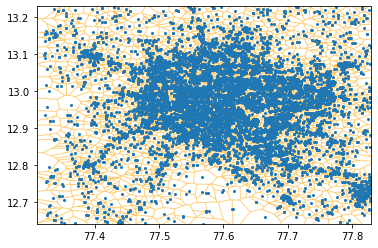

done for district Bangalore for category Education in time  65.72678279876709


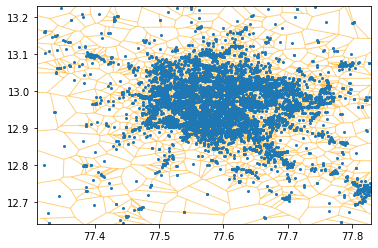

done for district Bangalore for category Health in time  124.8137595653534


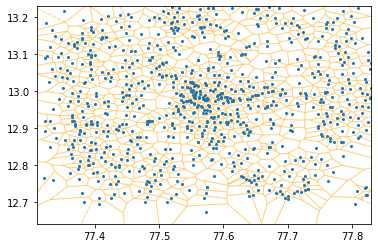

done for district Bangalore for category Connectivity in time  165.6010673046112


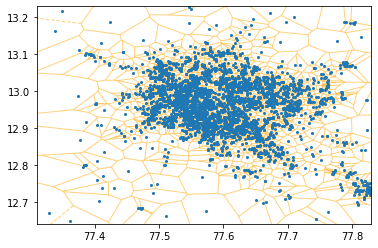

done for district Bangalore for category Utilities in time  211.55545377731323


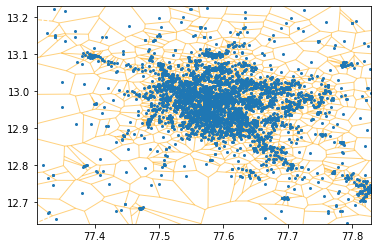

done for district Bangalore for category Government_Facilities in time  262.39749002456665


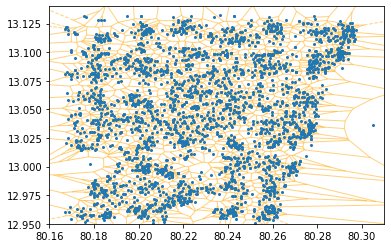

done for district Chennai for category Education in time  274.4939775466919


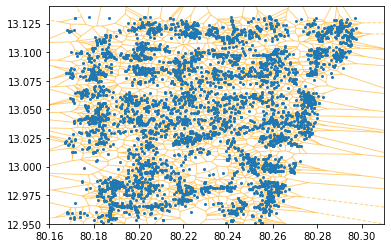

done for district Chennai for category Health in time  286.85976910591125


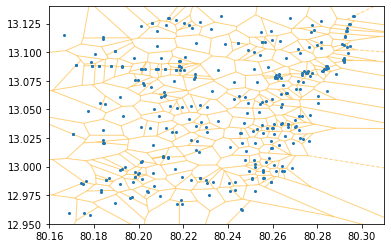

done for district Chennai for category Connectivity in time  293.3854742050171


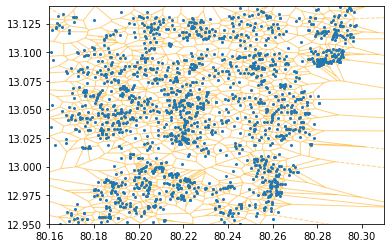

done for district Chennai for category Utilities in time  303.1949634552002


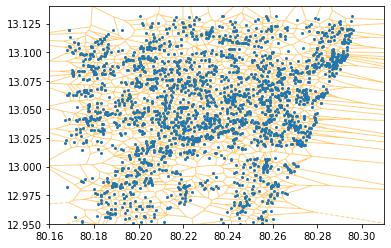

done for district Chennai for category Government_Facilities in time  313.3632981777191


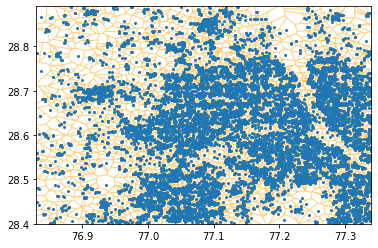

done for district Delhi for category Education in time  383.8587877750397


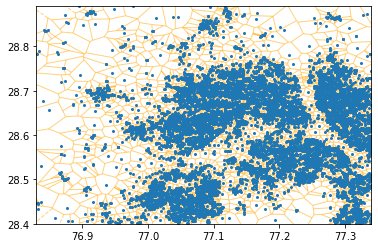

done for district Delhi for category Health in time  450.9814281463623


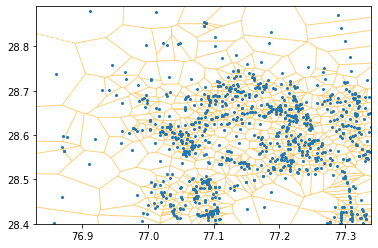

done for district Delhi for category Connectivity in time  490.3703489303589


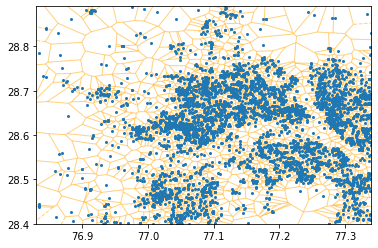

done for district Delhi for category Utilities in time  542.4952747821808


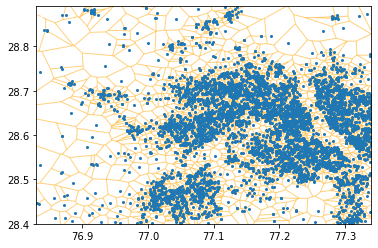

done for district Delhi for category Government_Facilities in time  597.9710087776184


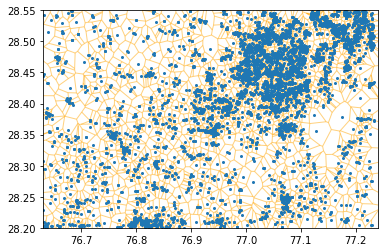

done for district Gurgaon for category Education in time  647.9729053974152


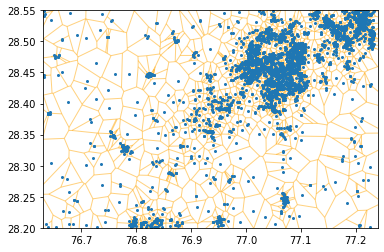

done for district Gurgaon for category Health in time  689.2801373004913


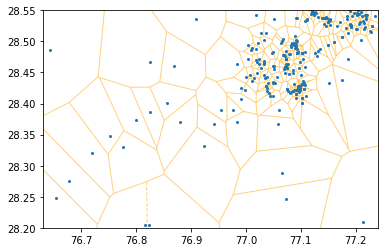

done for district Gurgaon for category Connectivity in time  708.6790590286255


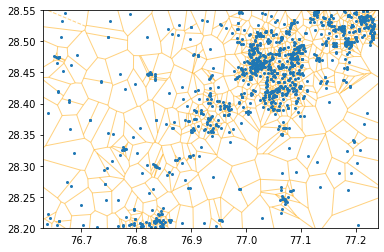

done for district Gurgaon for category Utilities in time  743.74400639534


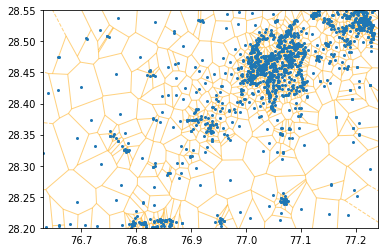

done for district Gurgaon for category Government_Facilities in time  778.4750456809998


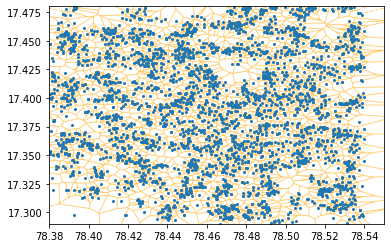

done for district Hyderabad for category Education in time  793.3388602733612


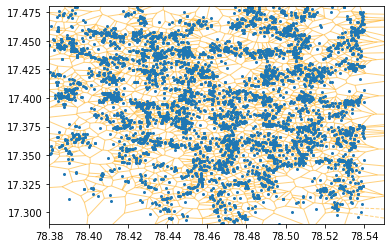

done for district Hyderabad for category Health in time  808.5017671585083


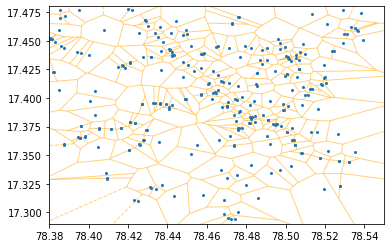

done for district Hyderabad for category Connectivity in time  816.2060024738312


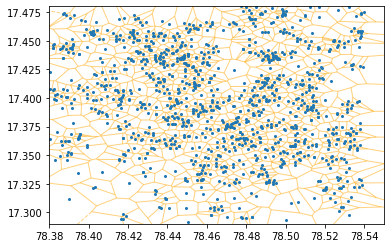

done for district Hyderabad for category Utilities in time  826.7199876308441


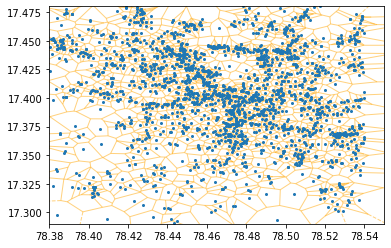

done for district Hyderabad for category Government_Facilities in time  838.6288321018219


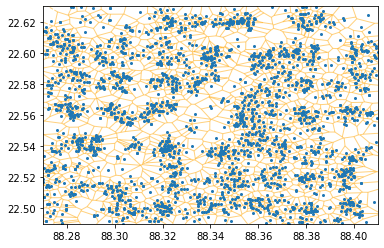

done for district Kolkata for category Education in time  849.1526620388031


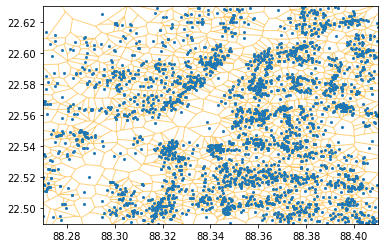

done for district Kolkata for category Health in time  859.3597536087036


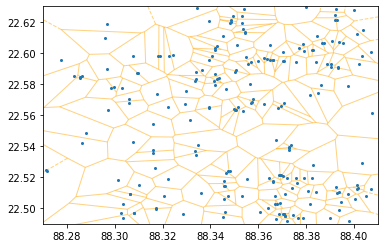

done for district Kolkata for category Connectivity in time  864.7220785617828


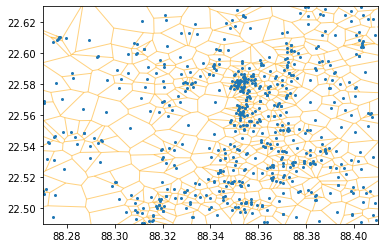

done for district Kolkata for category Utilities in time  871.1745562553406


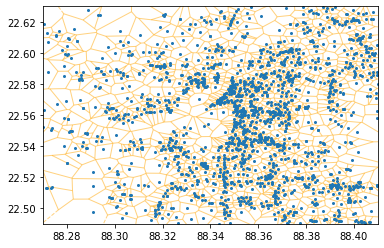

done for district Kolkata for category Government_Facilities in time  879.7344691753387


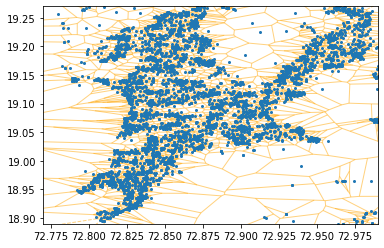

done for district Mumbai for category Education in time  900.0482876300812


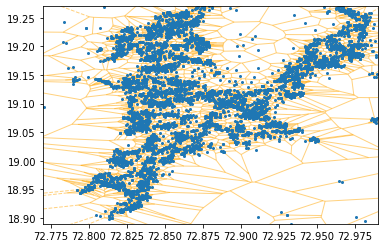

done for district Mumbai for category Health in time  921.9236416816711


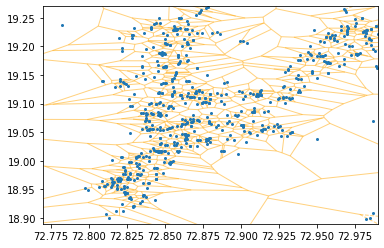

done for district Mumbai for category Connectivity in time  934.8999433517456


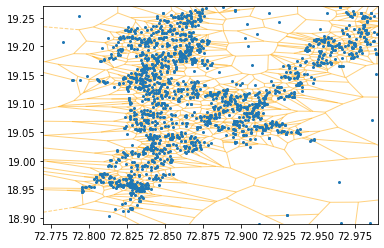

done for district Mumbai for category Utilities in time  950.2263205051422


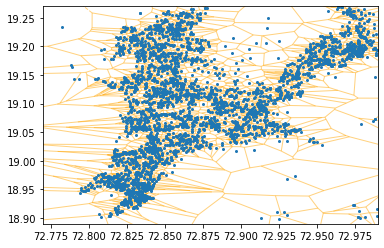

done for district Mumbai for category Government_Facilities in time  967.9305534362793


In [ ]:
start_time=time.time()
districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
category_dict={"Education":['school','primary_school'],"Health":['doctor','hospital'],"Connectivity":['train_station','taxi_stand','bus_station'],"Utilities":['department_store','supermarket'],"Government_Facilities":['local_government_office','police','bank']}
for i in range(len(districts)):
  for key in category_dict:
    (voronoi_sites_lat,voronoi_sites_lon,sites_population_arr,sites_area_arr,voronoi_sites_grid_num)=get_voronoi_parameters(districts[i],category_dict[key],dataset)
    data = {'Voronoi_Sites_Lat': voronoi_sites_lat, "Voronoi_Sites_Lon": voronoi_sites_lon, "Catchment_Polygon_Population": sites_population_arr, "Catchment_Polygon_Area": sites_area_arr, "Voronoi_Sites_Grid_Number": voronoi_sites_grid_num}
    df = pd.DataFrame(data, columns = data.keys())
    df.to_csv(districts[i]+'_voronoi_parameters_' + '_for_'+key+'_amenity_sites'+'.csv', index=False)
    print('done for district '+districts[i]+' for category '+key+' in time ',time.time()-start_time)

In [ ]:
def get_load_of_combined_grid_amenities(district_name, year, amenity_category):#80 percentile value is returned
  filename = district_name+'_voronoi_parameters__for_'+amenity_category+'_amenity_sites.csv'
  grids_info=get_grid_info(district_name,year)
  voronoi_parameters=pd.read_csv(filename)
  voronoi_parameters=voronoi_parameters.to_numpy()
  voronoi_sites_grid_num = voronoi_parameters[:,4]
  combined_grids_num = grids_info[:,0][np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
  filter_arr=np.array([],dtype=bool)
  for i in range(len(voronoi_sites_grid_num)):
    if (voronoi_sites_grid_num[i] in combined_grids_num):
      filter_arr=np.append(filter_arr,True)
    else:
      filter_arr=np.append(filter_arr,False)
  voronoi_parameters=voronoi_parameters[filter_arr]
  combined_grids_sites_pop=voronoi_parameters[:,2]
  # combined_grids_sites_area=voronoi_parameters[:,3]
  # print(combined_grids_sites_area,combined_grids_sites_pop)
  combined_grids_sites_load=combined_grids_sites_pop#/combined_grids_sites_area
  return_value=int(np.round(np.percentile(combined_grids_sites_load,80),0))
  return return_value

In [ ]:
districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
category_dict={"Education":[],"Health":[],"Connectivity":[],"Utilities":[],"Government_Facilities":[]}
for i in range(len(districts)):
  for key in category_dict:
    start_time=time.time()
    return_value=get_load_of_combined_grid_amenities(districts[i],2019,key)
    category_dict[key].append(return_value)
    print(return_value)
    print('done for district '+districts[i]+' for category '+key+' in time ',time.time()-start_time)
data = {'Districts': districts, "Education": category_dict["Education"], "Health": category_dict["Health"], "Connectivity": category_dict["Connectivity"], "Utilities": category_dict["Utilities"], "Government_Facilities": category_dict["Government_Facilities"]}
df = pd.DataFrame(data, columns = data.keys())
df.to_csv('Histogram_Data_of_population_in_combined_grid_amenities_catchment_area'+'.csv', index=False)

5471
done for district Bangalore for category Education in time  0.8739802837371826
2755
done for district Bangalore for category Health in time  0.7115068435668945
66646
done for district Bangalore for category Connectivity in time  0.5834090709686279
7270
done for district Bangalore for category Utilities in time  0.6300036907196045
6536
done for district Bangalore for category Government_Facilities in time  0.6194324493408203
3102
done for district Chennai for category Education in time  0.5410292148590088
1863
done for district Chennai for category Health in time  0.6732380390167236
26311
done for district Chennai for category Connectivity in time  0.4799172878265381
5092
done for district Chennai for category Utilities in time  0.4926483631134033
3207
done for district Chennai for category Government_Facilities in time  0.52427077293396
3166
done for district Delhi for category Education in time  1.4695641994476318
2263
done for district Delhi for category Health in time  1.303994

In [ ]:
def calc_hvs_dist(arr):#returns distance in meters
  # arr = np.append(grid_centre,grid_amenity_arr, axis=0)
  arr_in_radians = np.radians(arr)
  result_arr = haversine_distances(arr_in_radians)
  result_arr = (result_arr * 6371000)[0,1:]
  hvs_dist = np.min(result_arr)
  return hvs_dist

In [ ]:
def get_load_of_Cz_grid_amenities(district_name, year, amenity_category, z):#80 percentile value is returned
  filename = district_name+'_voronoi_parameters__for_'+amenity_category+'_amenity_sites.csv'
  grids_info=get_grid_info(district_name,year)
  voronoi_parameters=pd.read_csv(filename)
  voronoi_parameters=voronoi_parameters.to_numpy()
  # print(voronoi_parameters)
  # voronoi_sites_grid_num = voronoi_parameters[:,4]
  Cz_grids_num = grids_info[:,0][(grids_info[:,4]==z)]
  Cz_pop_arr=np.array([])
  for i in range(len(Cz_grids_num)):
    cz_grid_lat=grids_info[Cz_grids_num[i],1]
    cz_grid_lon=grids_info[Cz_grids_num[i],2]
    hvs_distance = float('inf')
    jth_grid_pop=-1
    for j in range(len(voronoi_parameters)):
      jth_site_lat=voronoi_parameters[j,0]
      jth_site_lon=voronoi_parameters[j,1]
      jth_hvs_dist=calc_hvs_dist(np.vstack((np.array([[cz_grid_lat,cz_grid_lon]]),np.array([[jth_site_lat,jth_site_lon]]))))
      if (jth_hvs_dist < hvs_distance):
        hvs_distance = jth_hvs_dist
        jth_grid_pop=voronoi_parameters[j,2]
    # print(Cz_grids_num[i], hvs_distance, jth_grid_pop)
    if ((amenity_category=='Education' or amenity_category=='Health' or amenity_category=='Government_Facilities') and (hvs_distance <= 2000)):
      if (jth_grid_pop != -1):
        Cz_pop_arr=np.append(Cz_pop_arr,jth_grid_pop)
    if ((amenity_category=='Connectivity' or amenity_category=='Utilities') and (hvs_distance<=800)):
      if (jth_grid_pop != -1):
        Cz_pop_arr=np.append(Cz_pop_arr,jth_grid_pop)
  if (len(Cz_pop_arr)==0):
    return -1
  else:
    return_value=int(np.round(np.percentile(Cz_pop_arr,80),0))
    return return_value

In [ ]:
districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
class_type=['C1','C2','C3','C4','C5']
mod_class_type=['C2','C3','C4','C5']
for i in range(len(districts)):
  if (i==4):
    category_dict={"Education":[],"Health":[],"Connectivity":[],"Utilities":[],"Government_Facilities":[]}
    for key in category_dict:
      start_time=time.time()
      for z in range(2,6,1):
        category_dict[key]=category_dict[key]+[get_load_of_Cz_grid_amenities(districts[i],2019,key,z)]
      print('done for district '+districts[i]+' for category '+key+' in time ',time.time()-start_time)
    data = {'Class': mod_class_type, "Education": category_dict["Education"], "Health": category_dict["Health"], "Connectivity": category_dict["Connectivity"], "Utilities": category_dict["Utilities"], "Government_Facilities": category_dict["Government_Facilities"]}
    df = pd.DataFrame(data, columns = data.keys())
    df.to_csv('Histogram_Data_of_population_in_Cz_grid_nearest_amenity_catchment_area_for_' + districts[i]+'.csv', index=False)
  else:
    category_dict={"Education":[],"Health":[],"Connectivity":[],"Utilities":[],"Government_Facilities":[]}
    for key in category_dict:
      start_time=time.time()
      for z in range(1,6,1):
        category_dict[key]=category_dict[key]+[get_load_of_Cz_grid_amenities(districts[i],2019,key,z)]
        # print('done for z= ',z)
      print('done for district '+districts[i]+' for category '+key+' in time ',time.time()-start_time)
    data = {'Class': class_type, "Education": category_dict["Education"], "Health": category_dict["Health"], "Connectivity": category_dict["Connectivity"], "Utilities": category_dict["Utilities"], "Government_Facilities": category_dict["Government_Facilities"]}
    df = pd.DataFrame(data, columns = data.keys())
    df.to_csv('Histogram_Data_of_population_in_Cz_grid_nearest_amenity_catchment_area_for_' + districts[i]+'.csv', index=False)

done for district Bangalore for category Education in time  71.32983875274658
done for district Bangalore for category Health in time  62.41466045379639
done for district Bangalore for category Connectivity in time  5.934782266616821
done for district Bangalore for category Utilities in time  23.85630512237549
done for district Bangalore for category Government_Facilities in time  25.740084171295166
done for district Chennai for category Education in time  16.413697004318237
done for district Chennai for category Health in time  24.372297525405884
done for district Chennai for category Connectivity in time  1.9448144435882568
done for district Chennai for category Utilities in time  8.709826707839966
done for district Chennai for category Government_Facilities in time  12.458643436431885
done for district Delhi for category Education in time  354.18370151519775
done for district Delhi for category Health in time  401.8953194618225
done for district Delhi for category Connectivity in ti

In [ ]:
def gini(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [ ]:
def calc_gini_index_for_population_distribution_in_combined_grids(district_name,year):
  filename=district_name+'_grid_population.csv'
  grids_info=get_grid_info(district_name,year)
  pop_arr=pd.read_csv(filename)
  pop_arr=pop_arr.to_numpy()
  pop_arr = pop_arr[:,1]
  combined_grids_pop = pop_arr[np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
  # print(combined_grids_pop)
  return gini(combined_grids_pop)

In [ ]:
districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
gini_index_arr=[]
for i in range(len(districts)):
  start_time=time.time()
  g_ind=calc_gini_index_for_population_distribution_in_combined_grids(districts[i],2019)
  gini_index_arr.append(g_ind)
  print('done for district '+districts[i]+' in time ',time.time()-start_time)
data = {'Districts': districts, 'Gini_Index': gini_index_arr}
df = pd.DataFrame(data, columns = data.keys())
df.to_csv('Gini_index_for_population_distribution_in_combined_grids.csv', index=False)

done for district Bangalore in time  0.06431365013122559
done for district Chennai in time  0.012491703033447266
done for district Delhi in time  0.05301403999328613
done for district Gurgaon in time  0.04375576972961426
done for district Hyderabad in time  0.012159109115600586
done for district Kolkata in time  0.009981393814086914
done for district Mumbai in time  0.021563053131103516


In [ ]:
def calc_gini_index_for_load_of_combined_grid_amenities(district_name, year, amenity_category):
  filename = district_name+'_voronoi_parameters__for_'+amenity_category+'_amenity_sites.csv'
  grids_info=get_grid_info(district_name,year)
  voronoi_parameters=pd.read_csv(filename)
  voronoi_parameters=voronoi_parameters.to_numpy()
  voronoi_sites_grid_num = voronoi_parameters[:,4]
  combined_grids_num = grids_info[:,0][np.logical_or((grids_info[:,3]=='Urban'),(grids_info[:,3]=='PeriUrban'))]
  filter_arr=np.array([],dtype=bool)
  for i in range(len(voronoi_sites_grid_num)):
    if (voronoi_sites_grid_num[i] in combined_grids_num):
      filter_arr=np.append(filter_arr,True)
    else:
      filter_arr=np.append(filter_arr,False)
  voronoi_parameters=voronoi_parameters[filter_arr]
  combined_grids_sites_pop=voronoi_parameters[:,2]
  return_value = gini(combined_grids_sites_pop)
  return return_value

In [ ]:
districts=['Bangalore','Chennai','Delhi','Gurgaon','Hyderabad','Kolkata','Mumbai']
category_dict={"Education":[],"Health":[],"Connectivity":[],"Utilities":[],"Government_Facilities":[]}
for i in range(len(districts)):
  for key in category_dict:
    start_time=time.time()
    return_value=calc_gini_index_for_load_of_combined_grid_amenities(districts[i],2019,key)
    category_dict[key].append(return_value)
    # print(return_value)
    print('done for district '+districts[i]+' for category '+key+' in time ',time.time()-start_time)
data = {'Districts': districts, "Education": category_dict["Education"], "Health": category_dict["Health"], "Connectivity": category_dict["Connectivity"], "Utilities": category_dict["Utilities"], "Government_Facilities": category_dict["Government_Facilities"]}
df = pd.DataFrame(data, columns = data.keys())
df.to_csv('Gini_Index_for_population_in_combined_grid_nearest_amenity_catchment_area'+'.csv', index=False)

done for district Bangalore for category Education in time  1.7743961811065674
done for district Bangalore for category Health in time  1.1333062648773193
done for district Bangalore for category Connectivity in time  0.5616507530212402
done for district Bangalore for category Utilities in time  0.5259273052215576
done for district Bangalore for category Government_Facilities in time  0.6504402160644531
done for district Chennai for category Education in time  0.850924015045166
done for district Chennai for category Health in time  0.5652520656585693
done for district Chennai for category Connectivity in time  0.299100399017334
done for district Chennai for category Utilities in time  0.431962251663208
done for district Chennai for category Government_Facilities in time  0.4817929267883301
done for district Delhi for category Education in time  2.1708168983459473
done for district Delhi for category Health in time  1.9170351028442383
done for district Delhi for category Connectivity in